In [68]:
import numpy as np
from scipy.integrate import odeint
import pandas as pd 
pd.set_option('display.float_format', '{:0.8f}'.format)
import warnings
import operator
import os, sys
# don't need this because I am not solving MM or through the equation, but I can import my own functions 
# from daeFinder import solveMM, plotToy_MM, plotToyEnz

from srh_traps import solve_srh_traps, plot_srh_solution


from daeFinder import add_noise_to_df
from daeFinder import smooth_data
from matplotlib import pyplot as plt
from daeFinder import PolyFeatureMatrix
from sklearn.preprocessing import StandardScaler
import sympy
from daeFinder import sequentialThLin, AlgModelFinder
from daeFinder import get_simplified_equation_list
from daeFinder import construct_reduced_fit_list
from sklearn.linear_model import LinearRegression
from daeFinder import get_refined_lib, remove_paranth_from_feat
from daeFinder import sequentialThLin, AlgModelFinder



Importing the Toy Model for SRH Recombination 

In [69]:
final_time = 1
num_time_points = 50
time_grid = np.linspace(0, final_time, num_time_points)
t_span = (0, final_time)

# Placeholder lists of parameter sets and initial conditions
params_list = [
    {"V": 0.7, "T": 300},  # Custom param example
]

IC_list = [
    # Original cases
    {"n": 1e12, "p": 1e5, "n_t": 1e10, "p_t": 1e10},
    {"n": 1e10, "p": 1e10, "n_t": 1e8, "p_t": 1e8},

    # New cases
    # Low injection condition
    {"n": 1e9, "p": 1e9, "n_t": 1e7, "p_t": 1e7},

    # High injection condition
    {"n": 1e15, "p": 1e15, "n_t": 1e12, "p_t": 1e12},

    # Trap-dominated regime (high traps, low carriers)

    # Trap-free approximation (carriers >> traps)
    {"n": 1e14, "p": 1e14, "n_t": 1e6, "p_t": 1e6},

    # Asymmetric cases
    {"n": 1e13, "p": 1e9, "n_t": 1e10, "p_t": 1e10},  # more electrons
    # {"n": 1e9, "p": 1e13, "n_t": 1e10, "p_t": 1e10},  # more holes
]


    # y0 = [1e10, 1e10, 1e8, 1e8]
constant = np.exp((-1*0.7)/(8.617e-5*300))
# Helper to wrap column names
def get_block_symbol(feature_list):
    return ["[{}]".format(feat) for feat in feature_list]

# Storage
data_matrix_df_list = []

# Loop over all combinations
for params in params_list:
    for IC in IC_list:
        sol = solve_srh_traps(IC, params, t_span=(time_grid[0], time_grid[-1]))
        t_interp = time_grid
        y_interp = np.vstack([np.interp(t_interp, sol.t, y) for y in sol.y])  # interpolate to match time grid
        sol_df = pd.DataFrame(y_interp.T, columns=["n", "p", "n_t", "p_t"])
        sol_df["t"] = t_interp

        # Rename columns to bracket notation
        sol_df = sol_df.rename(columns=dict(zip(sol_df.columns, get_block_symbol(sol_df.columns))))

        # # Add metadata (optional)
        # for k, v in IC.items():
        #     sol_df[f"[IC_{k}]"] = v
        # for k, v in params.items():
        #     sol_df[f"[param_{k}]"] = v

        data_matrix_df_list.append(sol_df)

# Concatenate into a single dataframe
data_matrix_df = pd.concat(data_matrix_df_list, ignore_index=True)
data_matrix_df


,[n],[p],[n_t],[p_t],[t]
0,1000000000000.00000000,100000.00000000,10000000000.00000000,10000000000.00000000,0.00000000
1,838946423568.21105957,296779482.13943279,170756896949.64987183,585875625.54943907,0.02040816
2,707631813229.48339844,364874916.95387238,302003411853.56298828,331236893.80742049,0.04081633
3,600587673707.69445801,405176775.82317257,409007249516.48266602,244593539.43431750,0.06122449
4,513208763518.31353760,433761017.11682874,496357575464.56994629,201476404.66149825,0.08163265
...,...,...,...,...,...
295,1265176843911.03466797,389986772.69127923,8745433169316.27832031,11434537.93366775,0.91836735
296,1264991963812.43994141,381975961.59755760,8745626060225.96679688,11434285.72169810,0.93877551
297,1264853545579.85791016,374282415.48012513,8745772172004.66601562,11434094.68457961,0.95918367
298,1264748021094.38989258,366813484.40280604,8745885165421.21191406,11433946.95760461,0.97959184


Adding Noise 

In [70]:
noise_perc = 0


data_matrix_features = data_matrix_df_list[0].columns
for ind, data_matrix_ in enumerate(data_matrix_df_list):
    t_exact = data_matrix_["[t]"]
    noisy_data_df = add_noise_to_df(data_matrix_, noise_perc=noise_perc, random_seed=111)
    noisy_data_df["[t]"] = t_exact
    data_matrix_df_list[ind] = noisy_data_df

In [71]:
data_matrix_smooth_df_list = [smooth_data(data_matrix,domain_var="[t]",derr_order=1, noise_perc=noise_perc,
                                          eval_points=t_exact) for data_matrix in data_matrix_df_list]

if len(data_matrix_df_list) >1:
    data_matrix_df_smooth_appended = pd.concat(data_matrix_smooth_df_list, ignore_index=True)
else:
    data_matrix_df_smooth_appended = data_matrix_smooth_df_list[0]

data_matrix_df_smooth = data_matrix_df_smooth_appended[data_matrix_features]
if "[t]" in data_matrix_df_smooth:
    data_matrix_df_smooth = data_matrix_df_smooth.drop("[t]", axis=1)

data_matrix_smooth_df_list

[          [t]                    [n]              d([n]) /dt  \
 0  0.00000000 1000000000000.00012207 -8712091015039.55664062   
 1  0.02040816  838946423568.21118164 -7117090025576.71289062   
 2  0.04081633  707631813229.48352051 -5797672337919.52832031   
 3  0.06122449  600587673707.69433594 -4730956852241.13671875   
 4  0.08163265  513208763518.31341553 -3858688560657.93066406   
 5  0.10204082  442047074731.90722656 -3139756954567.84228516   
 6  0.12244898  384085350691.67553711 -2563425306586.46337891   
 7  0.14285714  336721133384.16143799 -2089455197204.93798828   
 8  0.16326531  298196613537.21331787 -1704398266299.74438477   
 9  0.18367347  266673266354.07601929 -1389988191018.64404297   
 10 0.20408163  241066945346.35516357 -1133710193681.83129883   
 11 0.22448980  220048706218.35931396  -928981374204.38867188   
 12 0.24489796  202955144753.39102173  -752798996666.34082031   
 13 0.26530612  189066178020.69320679  -614254284187.17041016   
 14 0.28571429  177691850

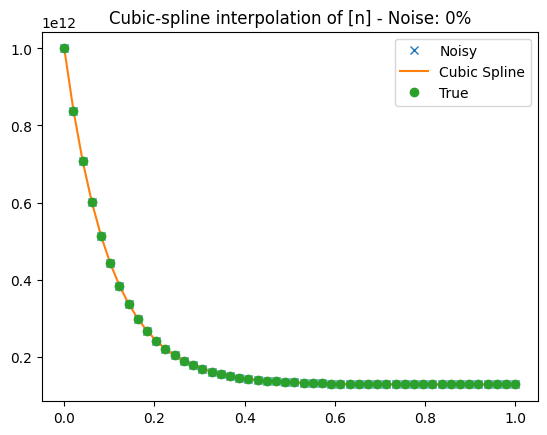

In [72]:
from matplotlib import pyplot as plt
ind = 0
feature_ = "[n]"

plt.figure()
# plt.plot(data_matrix_df_list[1]["t"], data_matrix_df_list[1]["x"], "x", t_eval_new, x_new,
#         data_matrix_df[50:100]["t"], data_matrix_df[50:100]["x"], "o")

plt.plot(data_matrix_df_list[ind]["[t]"], data_matrix_df_list[ind][feature_], "x", data_matrix_smooth_df_list[ind]["[t]"],
         data_matrix_smooth_df_list[ind][feature_],data_matrix_df[ind*num_time_points:(ind+1)*num_time_points]["[t]"], data_matrix_df[ind*num_time_points:(ind+1)*num_time_points][feature_], "o")
plt.legend(['Noisy', 'Cubic Spline', 'True'])
# plt.axis([-0.05, 6.33, -1.05, 1.05])
plt.title('Cubic-spline interpolation of {} - Noise: {}%'.format(feature_, noise_perc))
plt.show()

<Axes: >

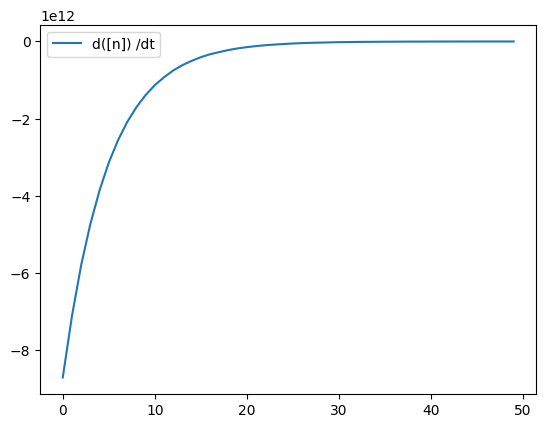

In [73]:
data_matrix_smooth_df_list[0][["d([n]) /dt"]].plot()


In [74]:
poly_degree = 2

poly_feature_ob = PolyFeatureMatrix(poly_degree)

candidate_lib_full = poly_feature_ob.fit_transform(data_matrix_df_smooth)


#Dropping 1 from the candidate library since we use fit_with_intercept flag instead of using constants directly
# in the candidate library
candidate_lib_full = candidate_lib_full.drop(["1"], axis=1)
candidate_lib_full

,[n],[p],[n_t],[p_t],[n]^2,[n] [p],[n] [n_t],[n] [p_t],[p]^2,[p] [n_t],[p] [p_t],[n_t]^2,[n_t] [p_t],[p_t]^2
0,1000000000000.00012207,99999.99999999,10000000000.00000572,10000000000.00000191,1000000000000000251658240.00000000,99999999999992448.00000000,10000000000000006291456.00000000,10000000000000002097152.00000000,9999999999.99848747,999999999999924.87500000,999999999999924.50000000,100000000000000114688.00000000,100000000000000081920.00000000,100000000000000032768.00000000
1,838946423568.21118164,296779482.13943285,170756896949.64987183,585875625.54943919,703831101617892361240576.00000000,248982085129302999040.00000000,143255887995514350731264.00000000,491518260710490505216.00000000,88078061018949936.00000000,50677143448453586944.00000000,173875864748678848.00000000,29157917855873346043904.00000000,100042303817257238528.00000000,343250248612946688.00000000
2,707631813229.48352051,364874916.95387238,302003411853.56304932,331236893.80742055,500742783094446675197952.00000000,258197099086025916416.00000000,213707221931427316629504.00000000,234393763773446881280.00000000,133133705022095264.00000000,110193469819854929920.00000000,120860034120041216.00000000,91206060771192820727808.00000000,100034672061617356800.00000000,109717879819188400.00000000
3,600587673707.69433594,405176775.82317257,409007249516.48266602,244593539.43431747,360705553809619921403904.00000000,243344177232023191552.00000000,245644712516686801010688.00000000,146899864852787920896.00000000,164168219666461440.00000000,165720238647392305152.00000000,99103621695174768.00000000,167286930157038311833600.00000000,100040530813531521024.00000000,59825999533007016.00000000
4,513208763518.31341553,433761017.11682868,496357575464.56988525,201476404.66149822,263383234951996137013248.00000000,222609955256973623296.00000000,254735057567119845621760.00000000,103399456514442854400.00000000,188148619970225728.00000000,215300566787154870272.00000000,87392610211013232.00000000,246370842721066202169344.00000000,100004339731099828224.00000000,40592741635323784.00000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,1265176843911.03491211,389986772.69127923,8745433169316.27929688,11434537.93366776,1600672446368687235006464.00000000,493402234240602865664.00000000,11064519535790448841850880.00000000,14466712614498779136.00000000,152089682874159488.00000000,3410603257488921329664.00000000,4459318545967097.00000000,76482601318977381588795392.00000000,99999987320903221248.00000000,130748657756486.89062500
296,1264991963812.44018555,381975961.59755766,8745626060225.96777344,11434285.72169810,1600204668510053913853952.00000000,483196521790439686144.00000000,11063146684694500812521472.00000000,14464279549883428864.00000000,145905635238378848.00000000,3340618924127473893376.00000000,4367622283726856.50000000,76485975185303584756465664.00000000,99999987187752615936.00000000,130742889965429.12500000
297,1264853545579.85815430,374282415.48012525,8745772172004.66699219,11434094.68457961,1599854491765938266832896.00000000,473412440268230033408.00000000,11062120940593760614481920.00000000,14462455202286336000.00000000,140087326537637104.00000000,3273388733776768008192.00000000,4279580577372919.00000000,76488530884611226602569728.00000000,99999987104462880768.00000000,130738521255931.79687500
298,1264748021094.38989258,366813484.40280604,8745885165421.21191406,11433946.95760461,1599587556862175312084992.00000000,463926628509186785280.00000000,11061340955685257864019968.00000000,14461061787928653824.00000000,134552132339727632.00000000,3208108611714966618112.00000000,4194125923995811.50000000,76490507326734816256196608.00000000,99999987078727188480.00000000,130735143029315.79687500


In [75]:
s_scaler = StandardScaler(with_std=True, with_mean=False)
scaled_cand_lib = pd.DataFrame(s_scaler.fit_transform(candidate_lib_full), columns=s_scaler.feature_names_in_)
if '1' in scaled_cand_lib.columns:
        scaled_cand_lib['1'] = 1

scaled_cand_lib.describe()


,[n],[p],[n_t],[p_t],[n]^2,[n] [p],[n] [n_t],[n] [p_t],[p]^2,[p] [n_t],[p] [p_t],[n_t]^2,[n_t] [p_t],[p_t]^2
count,300.00000000,300.00000000,300.00000000,300.00000000,300.00000000,300.00000000,300.00000000,300.00000000,300.00000000,300.00000000,300.00000000,300.00000000,300.00000000,300.00000000
mean,0.40865505,0.46215237,0.47692087,0.06227942,0.20750985,0.28665964,0.44248662,0.05882882,0.35751926,0.43505449,0.05970574,0.40815851,0.44732092,0.05784761
std,1.00167084,1.00167084,1.00167084,1.00167084,1.00167084,1.00167084,1.00167084,1.00167084,1.00167084,1.00167084,1.00167084,1.00167084,1.00167084,1.00167084
min,0.00000151,0.00000000,0.00000000,-0.00000000,0.00000000,0.00000000,0.00000000,-0.00000000,0.00000000,0.00000000,-0.00000000,0.00000000,-0.00000004,0.00000000
25%,0.00001673,0.00000265,0.00002789,0.00000136,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
50%,0.00937349,0.00000854,0.00195684,0.00019840,0.00001584,0.00000000,0.00000255,0.00000025,0.00000000,0.00000000,0.00000000,0.00000127,0.00013417,0.00000000
75%,0.16581689,0.23393380,0.28175833,0.00198303,0.00488910,0.00921815,0.02618373,0.00000045,0.01612391,0.02627858,0.00000000,0.02639895,0.00026833,0.00000023
max,8.27811968,4.42678311,3.34274043,17.35165716,12.18517186,9.58774145,3.28173548,17.35020386,5.77305641,3.34127234,17.35088604,3.71560137,2.68395115,17.34946389


In [76]:
feat_list = list(data_matrix_df.columns)
feat_list_str = ", ".join(remove_paranth_from_feat(data_matrix_df.columns))
exec(feat_list_str+ "= sympy.symbols("+str(feat_list)+")")
feat_list


['[n]', '[p]', '[n_t]', '[p_t]', '[t]']

In [77]:
algebraic_model_lasso = AlgModelFinder(model_id='lasso',
                                       fit_intercept=True)

algebraic_model_lasso.fit(data_matrix_df_smooth, scale_columns= True)

AlgModelFinder(fit_intercept=True)

In [78]:
#Best 10 models using R2 metrix
algebraic_model_lasso.best_models(5)

,[p],[n],[n_t],[p_t]
[n],1.19586908,NaN,0.00000000,0.00023354
[n_t],0.14081527,0.00000000,NaN,-0.00002748
[p_t],-0.00000000,380.71923088,-655.24263617,NaN
[p],NaN,0.40855685,1.35946991,-0.00000000
r2- metric,0.88589951,0.87118999,0.59763880,0.30140081


In [79]:

algebraic_model_lasso.get_fitted_intercepts()

{'[n]': np.float64(5355137048861.69),
 '[p]': np.float64(15127006977289.832),
 '[n_t]': np.float64(75459227423286.61),
 '[p_t]': np.float64(-2038247331.5121856)}

In [80]:
##THIS WAS NOT WORKING WHEN I PUT p IN 
# features_to_remove = {E}

# features_to_remove, refined_candid_lib = get_refined_lib(features_to_remove, data_matrix_df,
#                                                   candidate_lib_full, get_dropped_feat=True)

<Axes: >

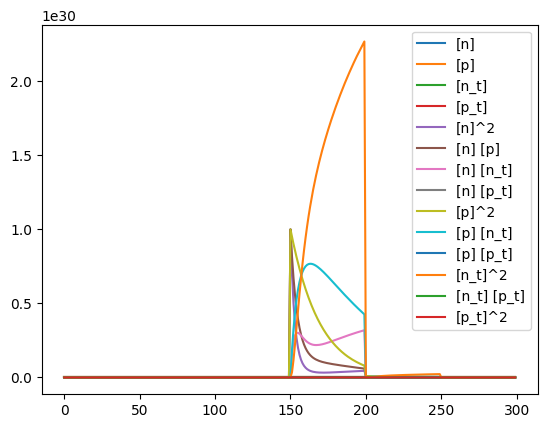

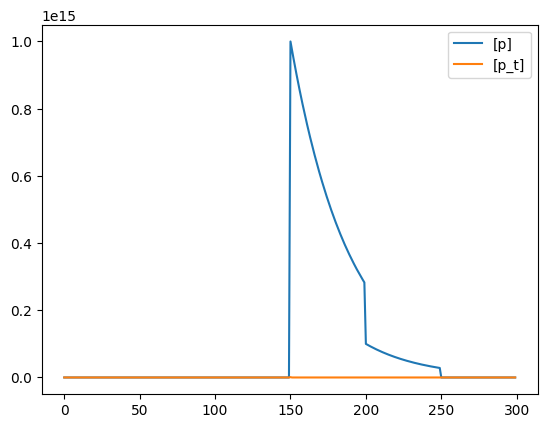

In [81]:

algebraic_model_lasso = AlgModelFinder(model_id='lasso',
                                       fit_intercept=False, alpha=0.2)
algebraic_model_lasso.fit(candidate_lib_full, scale_columns= True)
# algebraic_model_lasso.fit(scaled_cand_lib, scale_columns= False)

candidate_lib_full.plot()
data_matrix_df[['[p]','[p_t]']].plot()

In [82]:
# algebraic_model_lasso.best_models()
best_models_full = algebraic_model_lasso.best_models()

best_models_full

,[p] [p_t],[n] [p_t],[p_t]^2,[p_t],[n_t],[n] [p],[n_t] [p_t],[p],[n],[n_t]^2,[n] [n_t],[p]^2,[p] [n_t],[n]^2
[n],0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,168480219133722.78125000,0.00000000,0.00000000,NaN,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
[p],0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,442192380.76570374,NaN,0.07163493,0.00000000,0.00000000,419003017689723.93750000,192530832015053.31250000,0.00000000
[n_t],-0.00000000,-0.00000000,-0.00000000,0.00000000,NaN,0.00000000,171175706.64096311,0.00000000,0.00000000,1081727337255226.50000000,57934647065939.76562500,0.00000000,187013683770173.81250000,-0.00000000
[p_t],667918582288408.62500000,657020583952364.37500000,648135024143.27478027,NaN,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,-0.00000000,0.00000000,-0.00000000,49816168350587808.00000000
[n]^2,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.52927919,0.00000000,0.00000000,0.00000000,-0.00000000,0.00000000,0.00000000,-0.00000000,NaN
[n] [p],0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,NaN,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.45341887,0.00000000,0.54114284
[n] [n_t],-0.00000000,-0.00000000,-0.00000000,0.00000000,0.00000000,0.00000000,0.00000144,0.00000000,0.00000000,0.00000000,NaN,0.00000000,0.00000000,-0.00000000
[n] [p_t],0.13277866,NaN,0.00015251,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,-0.00000000,-0.00000000,0.00000000,-0.00000000,89.04228512
[p]^2,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.13914010,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,NaN,0.00000000,0.00000000
[p] [n_t],-0.00000000,-0.00000000,-0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,NaN,-0.00000000


In [83]:
intercept_dictionary = algebraic_model_lasso.get_fitted_intercepts()
intercept_dictionary

# simplified_equations = get_simplified_equation_list(best_model_df=best_models_full.fillna(0)[:-1],
#                             coef_threshold=0.05,
#                             intercept_threshold= 0.01,
#                              global_feature_list=data_matrix_df.columns,
#                              intercept_dict= intercept_dictionary,
#                              simplified = True)

{'[n]': np.float64(0.0),
 '[p]': np.float64(0.0),
 '[n_t]': np.float64(0.0),
 '[p_t]': np.float64(0.0),
 '[n]^2': np.float64(0.0),
 '[n] [p]': np.float64(0.0),
 '[n] [n_t]': np.float64(0.0),
 '[n] [p_t]': np.float64(0.0),
 '[p]^2': np.float64(0.0),
 '[p] [n_t]': np.float64(0.0),
 '[p] [p_t]': np.float64(0.0),
 '[n_t]^2': np.float64(0.0),
 '[n_t] [p_t]': np.float64(0.0),
 '[p_t]^2': np.float64(0.0)}